# Extractive Text Summarization

## Introduction

This Jupyter Notebook explores text summarization, comparing two extractive approaches. The first approach goes through the standard pre-processing steps (e.g. stop word elimination, lowercasing, etc.), uses GloVe word embeddings to establish a similarity matrix and, finally, employs the PageRank algorithm to establish a ranking of the text's constituent sentences and deriving a summary from the top-ranked phrases.

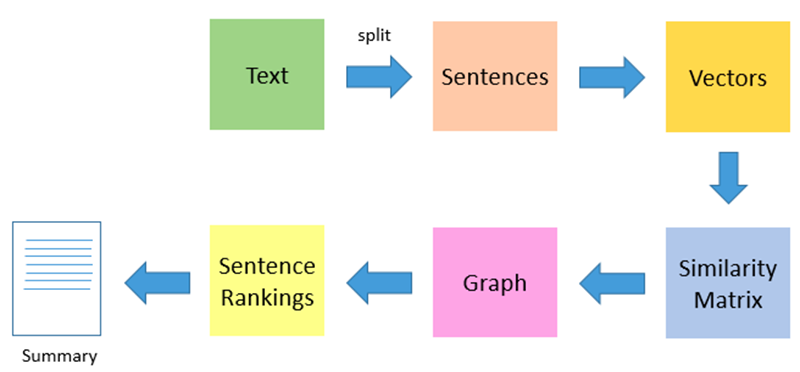

Source: Prateek, Joshi, [An Introduction to Text Summarization using the TextRank Algorithm](https://www.analyticsvidhya.com/blog/2018/11/introduction-text-summarization-textrank-python/). Retrieved 12-Jul-2020.

The second approach leverages the SpaCy framework to clean and tokenize the source text. It then examines the word frequencies within the text to establish a valuation of relevance for each sentence. This is subsequently ranked and serves as the basis for the extracted summary.

The conclusion examines and contrasts the two generated summaries and draws some conclusions before closing with points for further thought.


### Source Material and Inspiration

The general implementation approach to extractive summarization in the first example follows that used by Prateek Joshi in his article [An Introduction to Text Summarization using the TextRank Algorithm](https://www.analyticsvidhya.com/blog/2018/11/introduction-text-summarization-textrank-python/). Parts of the code have been adapted, re-written or extended.

The second approach explored here is adapted from a proposal by Luís Gonçalves titled [Automatic Text Summarization Made Simple with Python](https://medium.com/luisfredgs/automatic-text-summarization-made-simple-with-python-f9c3c645e34a).

The source text used for this analysis is by Carolyn Kormann. It's titled [The Coronavirus Vaccine Is on Track to Be the Fastest Ever Developed](https://www.newyorker.com/science/medical-dispatch/the-coronavirus-vaccine-is-on-track-to-be-the-fastest-ever-developed?itm_content=footer-recirc) and was published in the 22nd May 2020 issue of the New Yorker.

<hr>


## Initial Approach: Word Embedding and PageRank

In [70]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
import re

In [71]:
# Download the NLTK stopwords - we will need these later
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/mark/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [72]:
# Read the source article data
with open("article2.txt", "r", encoding="utf-8") as f:
    article_text = " ".join(f.readlines())

In [73]:
# Check the data: what does the first article look like?
print(article_text[:300])

In early April, as COVID-19 cases and deaths in New York City were rising to horrifying numbers, Tal Zaks, the chief medical officer of Moderna, a Cambridge-based biotech company, was concerned about time. In just three months, his company had created an experimental vaccine to inoculate against COV


In [74]:
# Tokenize the article texts into sentences
sentences = []
sentences.append(sent_tokenize(article_text))

sentences = [y for x in sentences for y in x] # flatten

In [75]:
# Let's have a look at what it looks like now
sentences[:5]

['In early April, as COVID-19 cases and deaths in New York City were rising to horrifying numbers, Tal Zaks, the chief medical officer of Moderna, a Cambridge-based biotech company, was concerned about time.',
 'In just three months, his company had created an experimental vaccine to inoculate against COVID-19, and begun to inject the vaccine into humans, under the guidance of the National Institute of Allergy and Infectious Diseases, in a Phase I clinical trial involving forty-five healthy men and women.',
 'This kind of speed in vaccine development was unprecedented, and largely derived from the revolutionary—and yet, on a large scale, untested—biomedical technology behind the Moderna vaccine.',
 'Still, if there was any chance of getting the vaccine federally licensed, and then manufactured into hundreds of millions of doses, in twelve to eighteen months—as Anthony Fauci, the director of the N.I.A.I.D., has said is the fastest possible timeline—Zaks knew that the company would have 

### Load GloVe Vectors

We will use Stanford's pre-trained GloVe vectors (https://nlp.stanford.edu/projects/glove/) from the "Wikipedia 2014 + Gigaword 5" corpus for word embeddings. The vocabulary size is 400K words with vectors of 100 dimensions.


In [76]:
# Load and extract the word vectors
word_embeddings = {}
f = open('/Users/mark/Desktop/202003 MAS Data Science/CAS Machine Intelligence/Deep Learning/glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

In [77]:
# Check that we have loaded what we need. There should be 400K entries:
len(word_embeddings)

400000

### Text Cleaning

In the following lines, we pre-process our text to ensure we have clean input for futher downstream processing. To do this we

* expand any word contractions, e.g. isn't --> is not
* remove special characters
* eliminate stopwords
* convert the text to lowercase


In [78]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [79]:
# Helper function to expand word contractions
def expand_contractions(sen):
    sen_new = " ".join([contraction_mapping[t] if t in contraction_mapping else t for t in sen])
    return sen_new

expanded_sentences = [expand_contractions(s.split(" ")) for s in sentences]

In [80]:
# Remove punctuation, numbers and special characters (the ^ caret is negation in this context)
clean_sentences = pd.Series(expanded_sentences).str.replace("[^a-zA-Z]", " ")

# Convert the text to lowercase
clean_sentences = [s.lower() for s in clean_sentences]

In [81]:
# Load the stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [82]:
# Helper function to remove stopwords
def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new

clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]

In [83]:
# Verify what the cleaned sentences look like
clean_sentences[:5]

['early april covid cases deaths new york city rising horrifying numbers tal zaks chief medical officer moderna cambridge based biotech company concerned time',
 'three months company created experimental vaccine inoculate covid begun inject vaccine humans guidance national institute allergy infectious diseases phase clinical trial involving forty five healthy men women',
 'kind speed vaccine development unprecedented largely derived revolutionary yet large scale untested biomedical technology behind moderna vaccine',
 'still chance getting vaccine federally licensed manufactured hundreds millions doses twelve eighteen months anthony fauci director n said fastest possible timeline zaks knew company would able prove vaccine potential expectation benefit put summer',
 'accomplish moderna would demonstrate three things first vaccine causes significant adverse side effects healthy people dosed second vaccine prevent disease mammals mice monkeys third vaccine induces neutralizing antibodies

### Word Embeddings

The pre-trained GloVe vectors loaded earlier can be used to determine how semantically similar a pair of words are. This is established by calculating their Euclidean distance (or cosine similarity). The larger the value, the closer they are in meaning. Since we are interested in establishing the semantic similarity of sentences, we will use an average of all word vector values that make up the sentence. This way, we can work with a single value.

In [84]:
from sklearn.metrics.pairwise import cosine_similarity

In [85]:
sentence_vectors = []

# Iterate through every sentence and establish a value by averaging all constituent word vectors
for i in clean_sentences:
  if len(i) != 0:
    v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()]) / (len(i.split())+0.001)
  else:
    v = np.zeros((100,))
  sentence_vectors.append(v)

Now that we have our sentence vectors, we can create a similarity matrix that allows us to compare every sentence with every other sentence in our dataset:

In [86]:
# Create a similarity matrix for all sentences
sim_mat = np.zeros([len(sentences), len(sentences)])

for i in range(len(sentences)):
  for j in range(len(sentences)):
    if i != j:
      sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]

In [87]:
# What does our similarity matrix look like?
print(sim_mat)
print(sim_mat.shape)

[[0.         0.80887303 0.79334268 ... 0.59542018 0.83336377 0.854455  ]
 [0.80887303 0.         0.85317809 ... 0.77764455 0.83021121 0.84892507]
 [0.79334268 0.85317809 0.         ... 0.77775222 0.84857792 0.84860653]
 ...
 [0.59542018 0.77764455 0.77775222 ... 0.         0.7044068  0.66448951]
 [0.83336377 0.83021121 0.84857792 ... 0.7044068  0.         0.89791477]
 [0.854455   0.84892507 0.84860653 ... 0.66448951 0.89791477 0.        ]]
(47, 47)


### Apply PageRank Algorithm To Rank The Top Sentences

In the next step, we derive a ranking of sentences to determine which ones are the most important for conveying the text's content. The PageRank algorithm - originally developed for ranking webpages based on the structure of incoming links - will be used to establish the ranking. To do this, the similarity matrix must be converted into a graph representation. Thus, each node or vertice will represent a sentence while the edges represent the similarity score between them.

In [88]:
import networkx as nx

# Create a graph representation of our matrix and calculate the PageRank scores
nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)

In [89]:
# Rank by score
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)

In [90]:
# Extract top 5 sentences as the summary
print("Summary of article using GloVe and TextRank")
print("---------------------------------------------------")
for i in range(5):
  print(ranked_sentences[i][1])

Summary of article using GloVe and TextRank
---------------------------------------------------
Still, if there was any chance of getting the vaccine federally licensed, and then manufactured into hundreds of millions of doses, in twelve to eighteen months—as Anthony Fauci, the director of the N.I.A.I.D., has said is the fastest possible timeline—Zaks knew that the company would have to be able to prove the vaccine’s potential, or an “expectation of benefit,” as he put it, by this summer.
Often, in Phase III case-driven trials of this kind, investigators and regulators want to have between sixty and a hundred cases of infection with clinical symptoms (the kind that make a person go to the doctor) in the placebo group.
“When does that expectation of benefit actually become strong enough to warrant exposing more and more people to an unknown risk?”
 On May 15th, Zaks received his answer in his in-box—a hundred-and-forty-page report analyzing the initial results.
“The biggest risk is how 

### Network Visualisation

For additional context, we generate a graphical representation of the network graph created above. The blue edges represent high similarity scores (i.e. over 0.85) while the lower similarity scores are shown as dotted red lines.


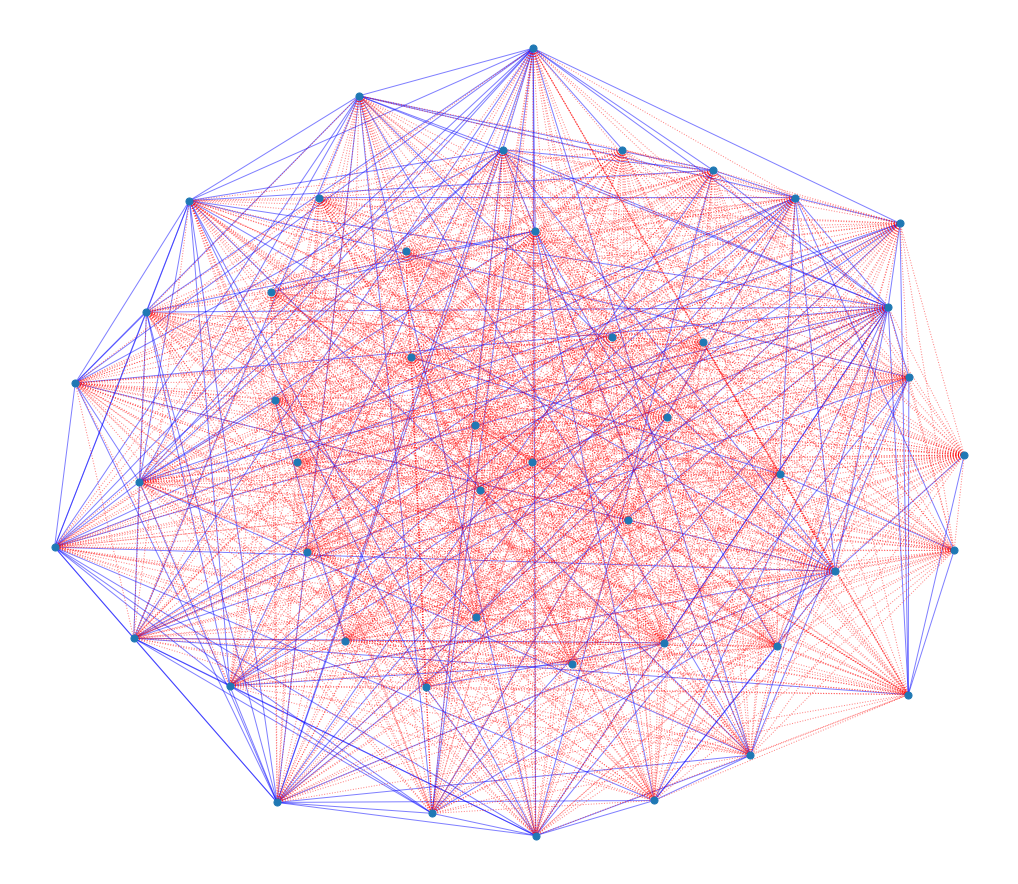

In [91]:
import matplotlib.pyplot as plt
plt.figure(num=None, figsize=(18,16), facecolor='w', edgecolor='k')

G = nx_graph

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 0.85]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] <= 0.85]

pos = nx.kamada_kawai_layout(G)

# nodes
nx.draw_networkx_nodes(G, pos, node_size=50)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=1, alpha=0.5, edge_color='b')
nx.draw_networkx_edges(G, pos, edgelist=esmall, width=1, alpha=0.5, edge_color='r', style='dotted')

# labels
#nx.draw_networkx_labels(G, pos, font_size=9, font_family='sans-serif')

plt.axis('off')
plt.show()

## An Alternative Approach: SpaCy and Word Frequencies

As an alternative approach to the above, I looked at Luís Gonçalves's approach as proposed in [Automatic Text Summarization Made Simple with Python](https://medium.com/luisfredgs/automatic-text-summarization-made-simple-with-python-f9c3c645e34a). This leverages SpaCy and word frequencies to determine the most important sentences in a text.


In [92]:
import spacy
from spacy.lang.en import English
from sklearn.feature_extraction.text import CountVectorizer
import en_core_web_lg

# For this approach, we will use spaCy's en_core_web_lg corpus based on OntoNotes 5 and GloVe
# It contains 685k unique vectors (300 dimensions)
nlp = en_core_web_lg.load()

In [93]:
# We can re-use the (unmodified) article source loaded above
doc = nlp(article_text)
print(len(article_text))

7627


### Text Cleaning

Again, we apply cleaning to the text, this time using SpaCy's functions to remove stopwords and normalize the text. Subsequently, we derive a document vocabulary and determine the frequency of occurence for each word within the text.

In [94]:
# We will apply the same cleaning here as in the first approach

# Convert to lowercase
corpus = [sent.text.lower() for sent in doc.sents]

# Remove stop words
cv = CountVectorizer(stop_words = 'english')

# Learn the document vocabulary
cv_fit = cv.fit_transform(corpus)

# Generate a dictionary of words along with their frequencies
word_list = cv.get_feature_names()
count_list = cv_fit.toarray().sum(axis=0)
word_frequency = dict(zip(word_list,count_list))

In [95]:
# What features has SpaCy extracted
word_list[:10]

['15th',
 '19',
 '1st',
 '2021',
 'ability',
 'able',
 'academic',
 'accelerate',
 'accomplish',
 'acids']

### Word Frequency and Sentence Ranking

The word frequency list is now sorted and we determine which words in the text occur with the highest frequency. The relative word frequencies are then summed up for each of the sentences in the text. This produces a value for each sentence, which in turn allows us to produce a ranking. In essence, sentences containing many high-frequency words rank higher than those containing words with lower frequency.


In [96]:
# The word frequency list looks like this
print(list(word_frequency.items())[:10])

[('15th', 1), ('19', 3), ('1st', 1), ('2021', 1), ('ability', 1), ('able', 2), ('academic', 1), ('accelerate', 1), ('accomplish', 1), ('acids', 1)]


In [97]:
# Sort the words by frequency and determine the words with most occurences
val = sorted(word_frequency.values())

highest_word_frequencies = [word for word, freq in word_frequency.items() if freq in val[-3:]]

print("\nWords with highest frequencies: ", highest_word_frequencies)

highest_frequency = val[-1]

for word in word_frequency.keys():  
    word_frequency[word] = (word_frequency[word]/highest_frequency)


Words with highest frequencies:  ['moderna', 'vaccine', 'zaks']


In [98]:
# The word_frequency dictionary now contains relative frequencies
print(list(word_frequency.items())[:10])

[('15th', 0.043478260869565216), ('19', 0.13043478260869565), ('1st', 0.043478260869565216), ('2021', 0.043478260869565216), ('ability', 0.043478260869565216), ('able', 0.08695652173913043), ('academic', 0.043478260869565216), ('accelerate', 0.043478260869565216), ('accomplish', 0.043478260869565216), ('acids', 0.043478260869565216)]


In [99]:
# Establish a sentence ranking based on the sum of the relative frequencies of the constituent words
sentence_rank = {}

for sent in doc.sents:
    for word in sent:
        if word.text.lower() in word_frequency.keys():
            if sent in sentence_rank.keys():
                sentence_rank[sent] += word_frequency[word.text.lower()]
            else:
                sentence_rank[sent] = word_frequency[word.text.lower()]
                top_sentences = (sorted(sentence_rank.values())[::-1])
                
top_sent = top_sentences[:5]

In [100]:
# The sentence_rank dictionary looks like this
list(sentence_rank.items())[:2]

[(In early April, as COVID-19 cases and deaths in New York City were rising to horrifying numbers, Tal Zaks, the chief medical officer of Moderna, a Cambridge-based biotech company, was concerned about time.,
  2.434782608695652),
 (In just three months, his company had created an experimental vaccine to inoculate against COVID-19, and begun to inject the vaccine into humans, under the guidance of the National Institute of Allergy and Infectious Diseases, in a Phase,
  3.2608695652173925)]

In [101]:
summary = []

for sent, strength in sentence_rank.items():  
    if strength in top_sent:
        summary.append(sent)
    else:
        continue

print("Summary of article using SpaCy and word frequencies")
print("---------------------------------------------------")

for i in summary:
    print(i, end=" ")

Summary of article using SpaCy and word frequencies
---------------------------------------------------
second, that the vaccine can prevent disease in other mammals, such as mice and monkeys; and, third, that the vaccine induces neutralizing antibodies in trial participants’ blood, which is tested by adding inoculated blood to a petri dish and seeing if the virus is prevented from infecting and killing cells in a tissue culture. With these results, Moderna and the N.I.A.I.D. could continue with their wildly ambitious plan to start Phase II trials almost immediately, in six hundred participants, with no limit on maximum age, and then, by July, to start Phase III efficacy trials, which will likely involve upward of ten thousand people. Stéphane Bancel, the C.E.O. of Moderna, said last week that, pending the results of the Phase III efficacy trial this summer, the vaccine could be ready for approval and licensing as soon as the fall. Then the investigators have to wait for people to stum

## Conclusion

The two approaches yield significantly different summarization results. Interestingly, though, they have one sentence in common: "Then the investigators have to wait for people to stumble into the virus or get infected; once there are significantly more cases among the placebo group, to prove that the vaccine is working, an independent review board will analyze the data and decide whether the trial is done."
While both summaries are certainly comprehensible (as would be expected with extractive approaches), and both provide an indication of what the underlying text is about, I believe the outcomes leave a lot of room for improvement. There is very little in the way of overall coherence in the sumamries. They give the impression of a more-or-less random sampling of sentences from the original text. As a next step, I could imagine comparing these approaches with an abstractive approach to explore the differences in results. However, it would also be interesting to make further refinements to the above approach. For example, one might consider taking into account the original text's paragraph structure and perhaps giving more weight to opening and closing phrases as these would be likely to contain cetral themes and conclusions. Possibly, this would yield slightly better summaries.


## References

* Allahyari, Mehdi et al., [Text Summarization Techniques: A Brief Survey](https://arxiv.org/pdf/1707.02268v3.pdf). Retrieved 12-Jul-2020.
* Aviv, Rachel, [Punishment by Pandemic](https://www.newyorker.com/magazine/2020/06/22/punishment-by-pandemic) in The New Yorker, published 22-Jun-2020. Retrieved 12-Jul-2020.
* Dubey, Praveen, [Understand Text Summarization and create your own summarizer in python](https://towardsdatascience.com/understand-text-summarization-and-create-your-own-summarizer-in-python-b26a9f09fc70). Retrieved 12-Jul-2020.
* Gonçalves, Luís, [Automatic Text Summarization Made Simple with Python](https://medium.com/luisfredgs/automatic-text-summarization-made-simple-with-python-f9c3c645e34a). Retrieved 12-Jul-2020.
* Joshi, Prateek, [An Introduction to Text Summarization using the TextRank Algorithm](https://www.analyticsvidhya.com/blog/2018/11/introduction-text-summarization-textrank-python/). Retrieved 12-Jul-2020.
* Kormann, Carolyn, [The Coronavirus Vaccine Is on Track to Be the Fastest Ever Developed](https://www.newyorker.com/science/medical-dispatch/the-coronavirus-vaccine-is-on-track-to-be-the-fastest-ever-developed?itm_content=footer-recirc) in The New Yorker, published 22-May-2020. Retrieved 12-Jul-2020.
* Liang, Xu, [Understand TextRank for Keyword Extraction by Python](https://towardsdatascience.com/textrank-for-keyword-extraction-by-python-c0bae21bcec0). Retrieved 12-Jul-2020.
* Panchal, Akash, [Sentence Extraction using NLTK: TextRank Algorithm](https://medium.com/analytics-vidhya/sentence-extraction-using-textrank-algorithm-7f5c8fd568cd). Retrieved 12-Jul-2020.
* Prabhakaran, Selva, [Cosine Similarity – Understanding the math and how it works](https://www.machinelearningplus.com/nlp/cosine-similarity/). Retrieved 12-Jul-2020.
